<a href="https://colab.research.google.com/github/vikrantmehta123/dl-for-coders-workbook/blob/main/Fastbook_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Practical Deep Learning for Coders: Chapter 6

Here we implement the notebook for the chapter six of the FastAI's book: Practical Deep Learning for Coders.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook

import fastbook

In [2]:
from fastbook import *
from fastai.vision.all import *
import pandas as pd

In [ ]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
Path.BASE_PATH = path
path.ls()

(#8) [Path('train.csv'),Path('segmentation'),Path('train.json'),Path('test.json'),Path('train'),Path('test.csv'),Path('test'),Path('valid.json')]

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


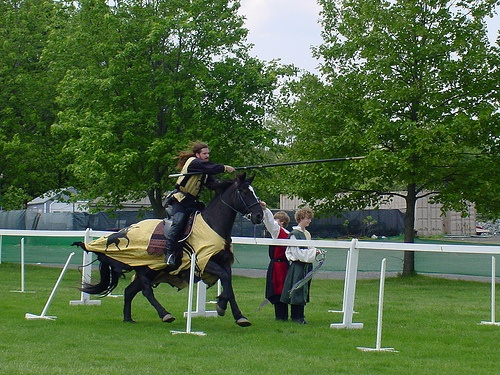

In [6]:
Image.open((path/'train/000009.jpg'))

In [7]:
dblock = DataBlock()

In [8]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [9]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [10]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

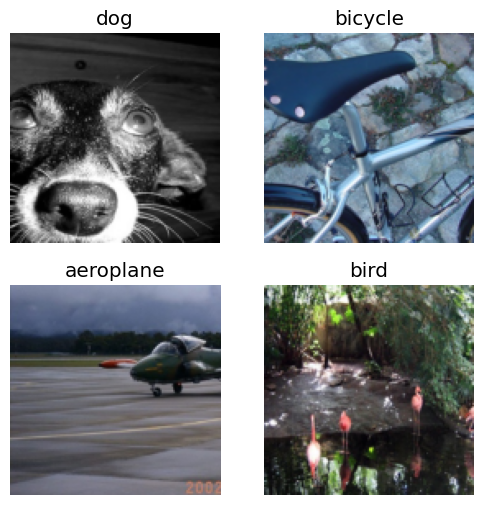

In [11]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

dls.show_batch(nrows=2, ncols=2)

In [ ]:
learn = vision_learner(dls, resnet18)

In [13]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [14]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [17]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [18]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.957897,0.707314,0.229064,00:25
1,0.828889,0.542470,0.301494,00:27
2,0.608157,0.192300,0.828207,00:26
3,0.361657,0.116410,0.945199,00:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.129618,0.102082,0.955418,00:25
1,0.113986,0.095930,0.957072,00:26
2,0.098661,0.095126,0.956016,00:26


In [19]:
preds,targs = learn.get_preds()

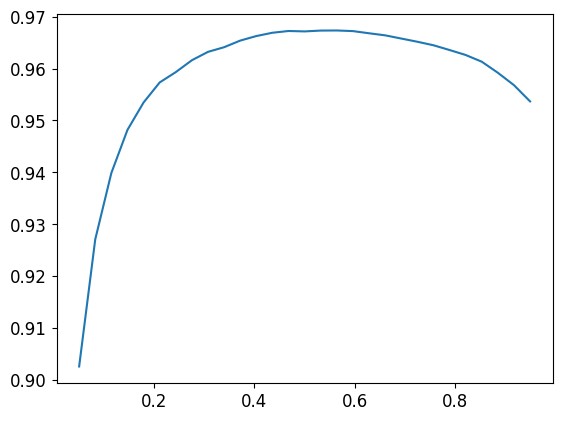

In [20]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

### Regression in Computer Vision

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [22]:
Path.BASE_PATH = path

In [23]:
path.ls()

(#50) [Path('11.obj'),Path('12'),Path('readme.txt'),Path('06.obj'),Path('09'),Path('03.obj'),Path('04'),Path('20.obj'),Path('24.obj'),Path('07')...]

In [24]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('12/frame_00646_pose.txt')

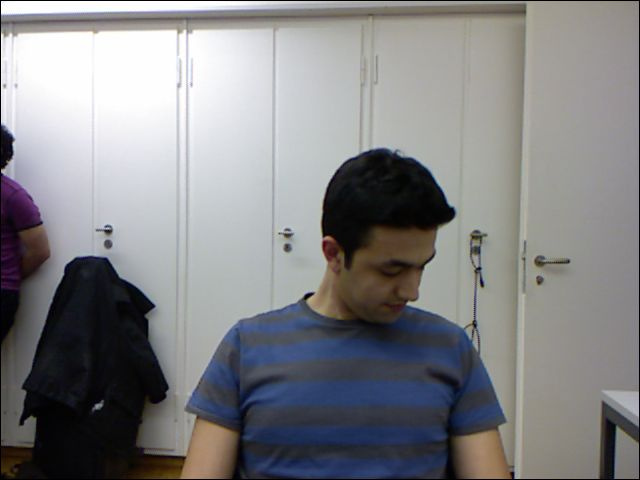

In [26]:
img = PILImage.create(img_files[0])
img

In [27]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

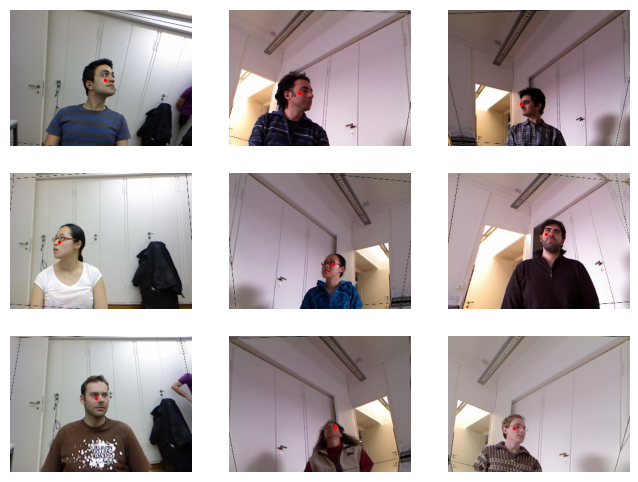

In [28]:
biwi = DataBlock(
    blocks=[ImageBlock, PointBlock],
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o:o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240, 320))
)

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [29]:
# TODO: Explore why the shape of each of the xb and yb is like that
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [30]:
learn = vision_learner(dls, resnet18, y_range=(-1, 1))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0008317637839354575)

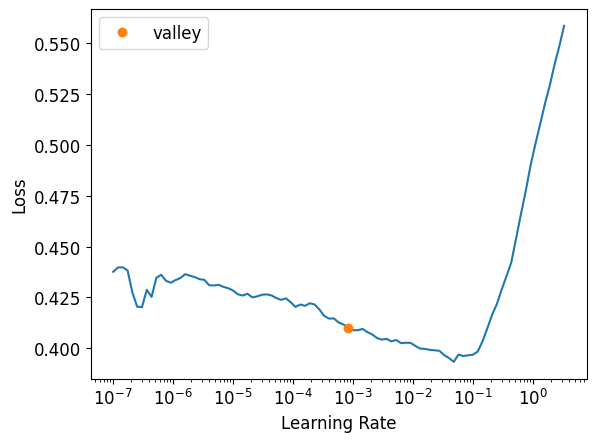

In [31]:
learn.lr_find()

In [32]:
lr = 1e-2
learn.fine_tune(2, lr)

epoch,train_loss,valid_loss,time
0,0.049684,0.018470,01:36


epoch,train_loss,valid_loss,time
0,0.006738,0.001229,01:51
1,0.001872,0.000196,01:51


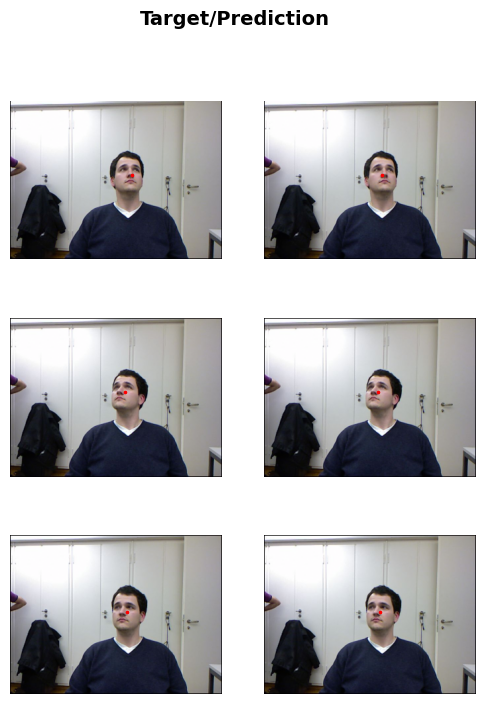

In [33]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))